data_manager.py
yfinacne api를 이용해 증권 시장 데이터를 불러오고 저장하는 모듈

In [229]:
import pandas as pd
import numpy as np
import yfinance as yf

WIKI = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(WIKI, storage_options={"User-Agent": "Mozilla/5.0"})
sp500 = tables[1]
sp500["ticker"] = sp500["Symbol"].astype(str).str.replace(".", "-", regex=False)
tickers = sp500["Symbol"].astype(str).str.replace(".", "-", regex=False).unique().tolist()


initial_df = yf.download(
    tickers=tickers,            
    period="3mo",
    interval="1d",
    auto_adjust=False,
    group_by="ticker",
    progress=False,
)

data = (
    initial_df
      .stack(0)                          
      .rename_axis(['date', 'ticker'])   
      .reset_index()[['ticker', 'date', 'Close', 'Volume']] 
      .sort_values(['ticker', 'date']) 
      .reset_index(drop=True)
)

sector = sp500[['ticker', 'GICS Sector']]
data = data.merge(sector, on='ticker', how='left')
data = data.sort_values(by=['ticker', 'date'])

data.to_csv('yfinance_data.csv')


/tmp/ipykernel_510/1893705286.py:23: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(0)


In [230]:
# 시장 지수 구하기
mkt_idx = yf.download(
    tickers="^GSPC",
    period="3mo",          
    interval="1d",
    auto_adjust=False,    
    progress=False,
)

mkt_idx = ( mkt_idx.
           reset_index()[['Date','Close']]
           .rename(columns={'Date':'date','Close':'SPX'}) 
           .sort_values('date') )

mkt_idx.columns = mkt_idx.columns.droplevel(1)
mkt_idx.columns.name = None

mkt_idx['mkt_ret_spx'] = mkt_idx['SPX'].pct_change()

preprocessing.py
1. data_manager.py를 통해 얻은 데이터로 일별 수익률을 구함
2. data_manger.py를 통해 얻은 데이터로 월별 상태를 구함(월별 평균 수익률, 분산, 표준편차)
3. 종목별 상관계수를 구함


In [231]:
import pandas as pd
import numpy as np


daily_returns = data.copy()
daily_returns['Daily_Return'] = daily_returns.groupby('ticker')['Close'].pct_change()
daily_returns = daily_returns.dropna(subset=['Daily_Return'])
monthly_stats = daily_returns.copy()
monthly_stats['YearMonth']  = monthly_stats['date'].dt.to_period('M')
monthly_stats = monthly_stats.groupby(['ticker', 'YearMonth']).agg(

    Monthly_Mean_Return=('Daily_Return', 'mean'),
    Monthly_Variance=('Daily_Return', 'var'),
    Monthly_Std_Dev=('Daily_Return', 'std')
).reset_index()

daily_returns.to_csv('daily_returns.csv')
monthly_stats.to_csv('monthly_stats.csv')



In [232]:
import numpy as np
import pandas as pd


merged = daily_returns.merge(mkt_idx, on='date', how='left')[['ticker','date','Daily_Return','mkt_ret_spx']]

Y = merged.pivot(index='date', columns='ticker', values='Daily_Return').dropna(how='all')
m = (
    merged.drop_duplicates('date')
          .set_index('date')['mkt_ret_spx']
          .reindex(Y.index)
)


y = Y.values
z = m.values.reshape(-1, 1)

y_mean = np.nanmean(y, axis=0, keepdims=True)
z_mean = np.nanmean(z, axis=0, keepdims=True)
y0 = y - y_mean
z0 = z - z_mean

beta  = (z0.T @ y0) / (z0.T @ z0)
alpha = y_mean - beta * z_mean
E = y - (alpha + z @ beta)


resid_df    = pd.DataFrame(E, index=Y.index, columns=Y.columns)
year_month  = resid_df.index.to_period('M')

corr_monthly = (
    resid_df
      .groupby(year_month)
      .apply(lambda df: df.corr())
)

corr_monthly = corr_monthly.rename_axis(index=['YearMonth','ticker1'], columns='ticker2')

corr_data = (
    corr_monthly
      .stack(dropna=False)          
      .rename('Correlation')
      .reset_index()
      .query('ticker1 < ticker2')  
      .set_index(['YearMonth','ticker1','ticker2'])
      .sort_index()
)

/tmp/ipykernel_510/265621070.py:41: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


In [254]:
from scipy import stats

ALPHA = 0.01        
C_MIN = 0.8

n_tbl = (
    resid_df.notna().astype(int)
    .groupby(resid_df.index.to_period('M'))
    .apply(lambda m: pd.DataFrame(m.T @ m, index=m.columns, columns=m.columns))
    .rename_axis(index=['YearMonth', 'ticker1'], columns='ticker2')
    .stack()
    .rename('n')
    .reset_index()
    .query('ticker1 < ticker2')
    .set_index(['YearMonth', 'ticker1', 'ticker2'])
)


df = corr_data.join(n_tbl, how='inner').dropna(subset=['Correlation', 'n'])
r = df['Correlation'].to_numpy(float)
n = df['n'].to_numpy(int)

dfree = n - 2 - 1                        #
r_safe = np.clip(r, -0.999999, 0.999999)
with np.errstate(divide='ignore', invalid='ignore'):
    tval = r_safe * np.sqrt(np.where(dfree > 0, dfree, np.nan) / (1.0 - r_safe**2))
pval = 2.0 * stats.t.sf(np.abs(tval), df=np.where(dfree > 0, dfree, 1))
pval[(dfree < 1) | ~np.isfinite(pval)] = 1.0

df['pval'] = pval

p_edges = df[(df['pval'] < ALPHA) & (df['Correlation'].abs() >= C_MIN)].sort_index()

create_network.py
1. 섹터별 색상 지정
2. 상관관계 기반 네트워크 구성
3. 섹터별로 노드 색칠


In [240]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#불러와야하는 데이터
#data
#corr_data
sector_data = data[['ticker','GICS Sector']].set_index('ticker')

In [235]:
def map_beta_to_gradient_color(beta):
    """
    산업 섹터별로 색깔을 부여하는 함수
    Args: 
        beta (float): 해당 섹터의 위험도
    Returns:
        섹터에 부여된 색깔
    """
    if beta < 0.50:
        return '#5DADE2' 
    elif beta < 0.60:
        return '#85C1E9'  
    elif beta < 0.70:
        return '#AED6F1'  
    elif beta < 0.85:
        return '#A3E4D7'  
    elif beta < 1.00:
        return '#76D7C4' 
    elif beta < 1.05:
        return '#F7DC6F'  
    elif beta < 1.10:
        return '#F1C40F'  
    elif beta < 1.15:
        return '#EB984E'  
    elif beta < 1.20:
        return '#C0392B'  
    else: 
        return '#7D3C98'


# 사전에 매핑한 산업 섹터별 위험도
sector_avg_beta = {
    'Consumer Staples': 0.454, 'Utilities': 0.681, 'Energy': 0.684,
    'Health Care': 0.826, 'Real Estate': 0.989, 'Communication Services': 1.019,
    'Financials': 1.037, 'Materials': 1.059, 'Industrials': 1.094,
    'Consumer Discretionary': 1.171, 'Information Technology': 1.246
}
final_sector_color_map = {
    sector: map_beta_to_gradient_color(beta)
    for sector, beta in sector_avg_beta.items()
}

# 각각의 티커의 산업 섹터를 가져와서 해당 티커에 산업 섹터의 색깔을 매핑함
all_tickers = sector_data.index.unique()
final_ticker_color_map = {}
for ticker in all_tickers:
    sector = sector_data.loc[ticker, 'GICS Sector'][0]
    color = final_sector_color_map.get(sector, '#AAAAAA')
    final_ticker_color_map[ticker] = color

/tmp/ipykernel_510/4267260090.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector = sector_data.loc[ticker, 'GICS Sector'][0]


In [247]:
def create_correlation_network(month_df, ticker_color_map):
    G = nx.Graph()
    for (t1, t2), row in month_df.iterrows():
        w = abs(row['Correlation'])
        G.add_edge(t1, t2, weight=w)
    edge_weights = [d['weight']  for *_, d in G.edges(data=True)]
    node_colors_list = [ticker_color_map.get(n, '#AAAAAA') for n in G.nodes()]
    return G, edge_weights, node_colors_list

In [265]:
def get_grouped_layout_pos(
    graph,
    ticker_color_map,
    optimal_dist=3.0,
    seed=42,
    *,
    method: str = "kk",     # "kk"(kamada-kawai) 또는 "spring"
    boost: float = 1.4,     # 같은 섹터(같은 색) 간 엣지 가중치 배수
    weight_power: float = 1.0,  # 상관 가중치 변환: |w|**weight_power
    jitter: float = 0.05   # 좌표에 아주 작은 난수 추가(겹침 완화)
):
    """
    graph: nx.Graph()
    ticker_color_map: {ticker: color(str/tuple)}
    optimal_dist: spring_layout의 k
    method: "kk" 또는 "spring"
    boost: 같은 섹터(색 동일)인 노드 쌍의 엣지 가중치 배수
    weight_power: |corr| -> |corr|**power 로 스케일링
    jitter: 좌표 난수 표준편차(0이면 없음)
    """
    G_layout = graph.copy()

    # 가중치 전처리: 절댓값 + 스케일링 + 섹터(색) 동일 시 boost
    for u, v, d in G_layout.edges(data=True):
        w = float(d.get("weight", 0.0))
        w = abs(w) ** weight_power
        if ticker_color_map.get(u) == ticker_color_map.get(v):
            w *= boost
        d["__w"] = w if np.isfinite(w) else 0.0

    # 레이아웃 선택
    if method.lower() == "kk":
        pos = nx.kamada_kawai_layout(G_layout, weight="__w")
    else:
        pos = nx.spring_layout(
            G_layout, weight="__w", seed=seed, k=optimal_dist, iterations=300
        )

    # 미세 지터로 겹침 완화(옵션)
    if jitter > 0:
        rng = np.random.default_rng(seed)
        for n in pos:
            pos[n] = pos[n] + rng.normal(0.0, jitter, 2)

    return pos


[2025-08] 노드 수: 412 | 엣지 수: 2,766


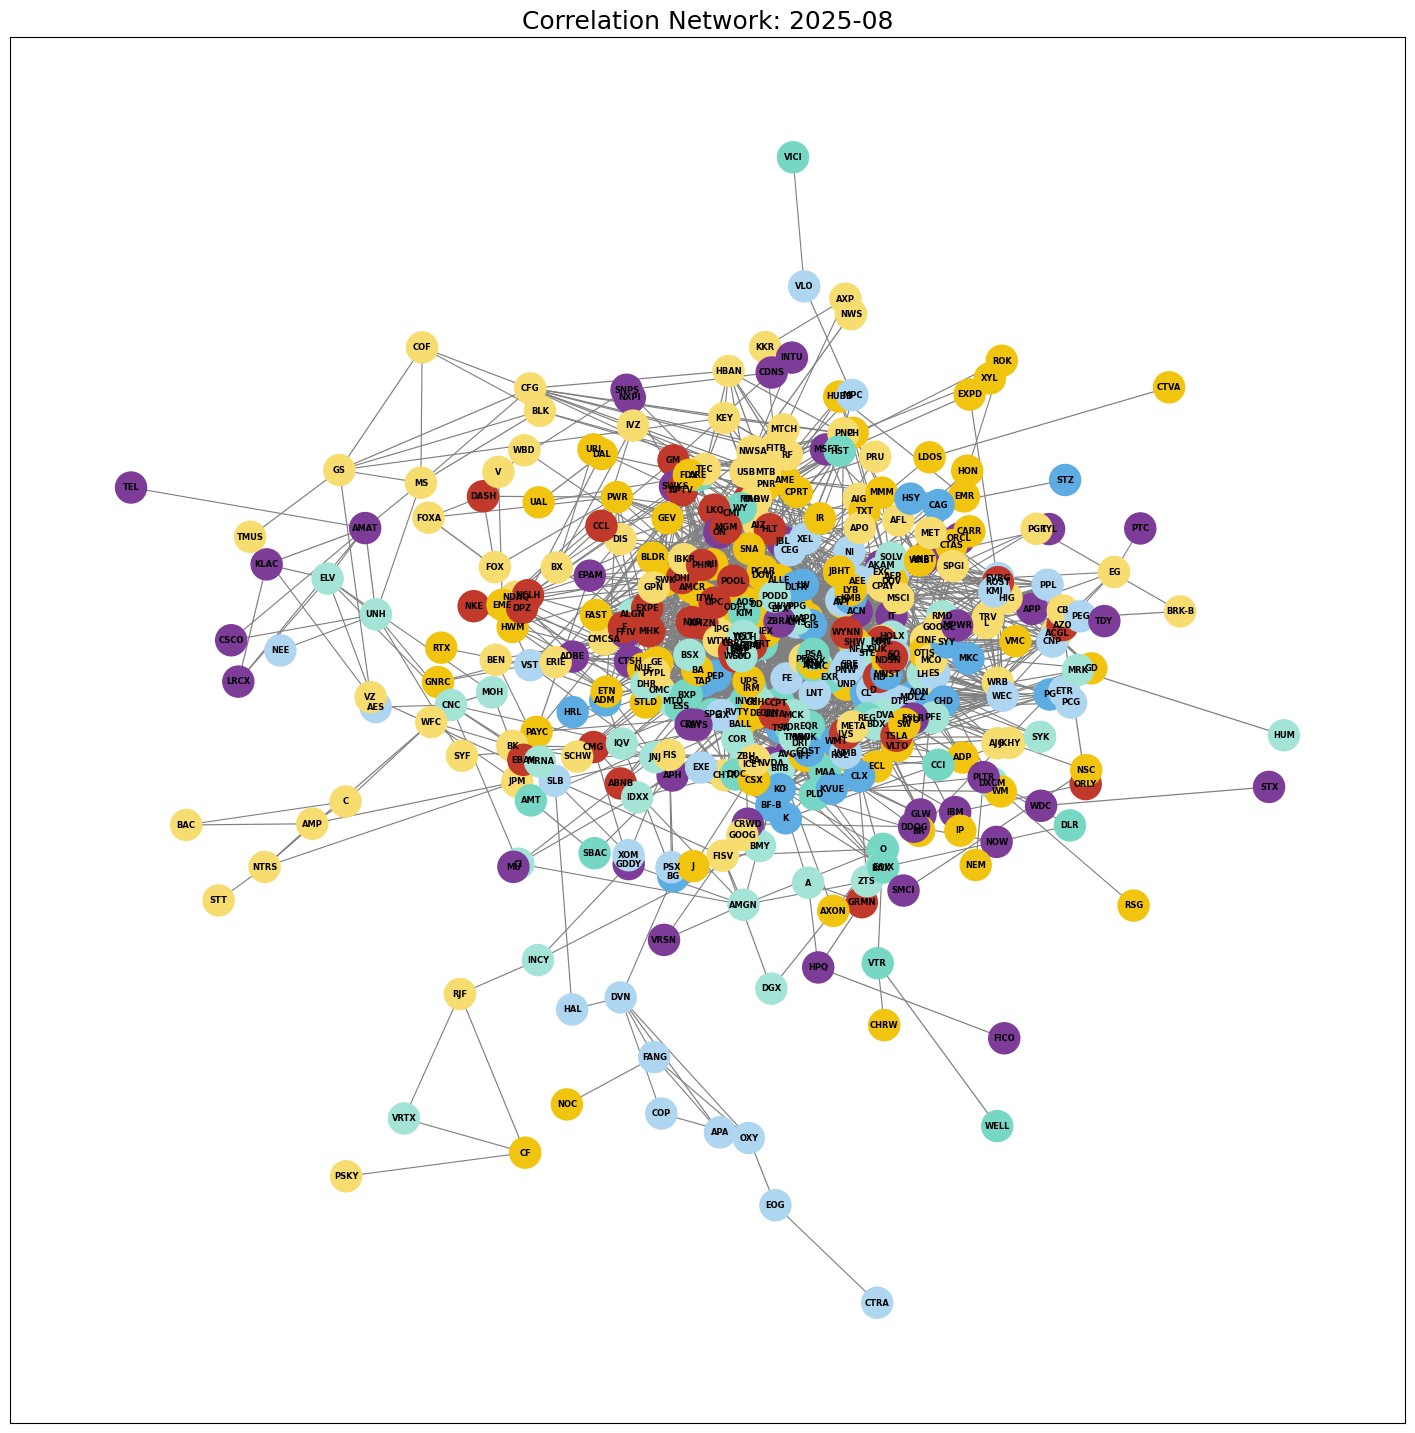

In [266]:
# 네트워크 생성 예시
grouped_by_month = p_edges.groupby(level='YearMonth')  # level로 그룹
all_months = sorted(p_edges.index.get_level_values('YearMonth').unique())
target_month = all_months[0]

month_edges = p_edges.xs(target_month, level='YearMonth')  # 2-레벨로 슬라이스

G, edge_w, node_c = create_correlation_network(
    month_edges,
    final_ticker_color_map,
)
print(f"[{target_month}] 노드 수: {G.number_of_nodes():,} | 엣지 수: {G.number_of_edges():,}")
pos = get_grouped_layout_pos(G, final_ticker_color_map)

plt.figure(figsize=(18, 18))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_size=500,
    node_color=node_c,
    edge_color='gray',
    width=edge_w,
    font_size=6,
    font_weight='bold'
)
plt.title(f"Correlation Network: {target_month}", fontsize=18)
plt.show()